In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
train = pd.read_csv('/kaggle/input/bizinnovate-2023/train.csv')
test = pd.read_csv('/kaggle/input/bizinnovate-2023/test_masked.csv')

In [94]:
geotrain = (gpd.GeoDataFrame(
                train, 
                crs="EPSG:4326", # specify the CRS
                geometry=gpd.points_from_xy(train["lon"], train["lat"])) # create geometry from coordinates
            ).to_crs("EPSG:7755")
geotrain["Easting"], geotrain["Northing"] = geotrain.geometry.x, geotrain.geometry.y
geotrain.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,urban,path,geometry,Easting,Northing
0,IA-2015-7-00010004,IA,2015,9.165413,92.742696,22.0,2.650768,22.0,5.000000,10004,1,R,dhs_train/IA-2015-7-00010004.npz,POINT (5416606.481 2436667.776),5.416606e+06,2.436668e+06
1,IA-2015-7-00010005,IA,2015,8.307356,93.093792,22.0,2.157784,22.0,5.000000,10005,1,R,dhs_train/IA-2015-7-00010005.npz,POINT (5464464.046 2344356.890),5.464464e+06,2.344357e+06
2,IA-2015-7-00010007,IA,2015,7.016968,93.893226,21.0,1.832751,21.0,4.619048,10007,1,R,dhs_train/IA-2015-7-00010007.npz,POINT (5567922.849 2208082.479),5.567923e+06,2.208082e+06
3,IA-2015-7-00010016,IA,2015,9.194938,92.800432,22.0,2.746096,22.0,5.000000,10016,1,R,dhs_train/IA-2015-7-00010016.npz,POINT (5422707.281 2440543.195),5.422707e+06,2.440543e+06
4,IA-2015-7-00010018,IA,2015,8.055606,93.543892,22.0,2.581869,22.0,5.000000,10018,1,R,dhs_train/IA-2015-7-00010018.npz,POINT (5517371.176 2320920.304),5.517371e+06,2.320920e+06


In [95]:
geotest = (gpd.GeoDataFrame(
            test, 
            crs="EPSG:4326", # specify the CRS
            geometry=gpd.points_from_xy(test["lon"], test["lat"])) # create geometry from coordinate
            ).to_crs("EPSG:7755")
geotest["Easting"], geotest["Northing"] = geotest.geometry.x, geotest.geometry.y
geotest.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,cluster_id,adm1dhs,urban,path,geometry,water_index,Easting,Northing
0,IA-2015-7-00010009,IA,2015,9.220903,92.781530,22.0,2.721812,10009,1,R,dhs_valid/IA-2015-7-00010009.npz,POINT (5420348.782 2443248.747),5.000000,5.420349e+06,2.443249e+06
1,IA-2015-7-00010011,IA,2015,7.028410,93.883430,20.0,2.287279,10011,1,R,dhs_valid/IA-2015-7-00010011.npz,POINT (5566693.545 2209261.774),4.834646,5.566694e+06,2.209262e+06
2,IA-2015-7-00010017,IA,2015,12.371448,92.783665,22.0,0.677109,10017,1,R,dhs_valid/IA-2015-7-00010017.npz,POINT (5388812.515 2792492.064),4.192098,5.388813e+06,2.792492e+06
3,IA-2015-7-00010044,IA,2015,11.727304,92.719257,21.0,1.793683,10044,1,R,dhs_valid/IA-2015-7-00010044.npz,POINT (5388267.741 2720787.926),4.980362,5.388268e+06,2.720788e+06
4,IA-2015-7-00010060,IA,2015,9.185310,92.777645,22.0,2.758168,10060,1,R,dhs_valid/IA-2015-7-00010060.npz,POINT (5420279.276 2439239.328),5.000000,5.420279e+06,2.439239e+06


In [83]:
# from https://github.com/SimonMolinsky/geoprocessing/blob/master/data%20analysis/notebooks/spatial_101/0103_spatial_analysis/idw-3D-function.ipynb
def interpolate_values(array_of_coordinates, array_of_known_points):
    output_arr = []
    
    for row in array_of_coordinates:
        interpolated = inverse_distance_weighting(row, array_of_known_points, power=1, ndist=10)
        interpol_arr = np.zeros(shape=(1, len(row) + 1))
        interpol_arr[:, :-1] = row
        interpol_arr[:, -1] = interpolated
        output_arr.append(interpol_arr[0])
        
    return np.array(output_arr)

def inverse_distance_weighting(unknown_point, points, power, ndist=10):
    """
    Function estimates values in unknown points with with inverse weighted interpolation technique.
    
    INPUT:
    :param unknown_point: coordinates of unknown point,
    :param points: (array) list of points and they values [dim 1, ..., dim n, val],
    :param power: (float) constant used to calculate IDW weight -> weight = 1/(distance**power),
    :param ndist: (int) how many closest distances are included in weighting,
    
    OUTPUT:
    :return interpolated_value: (float) interpolated value by IDW method.
    
    Inverse distance weighted interpolation is:
    
    est = SUM(WEIGHTS * KNOWN VALS) / SUM(WEIGHTS)
    and
    WEIGHTS = 1 / (DISTANCE TO UNKNOWN**power)
    
    where:
    power is a constant hyperparameter which tells how much point is influenced by other points. 
    """

    distances = calculate_distances(points[:, :-1], unknown_point)
    vals_and_dists = np.c_[points[:, -1], distances]
    
    # Sort and get only 10 values
    vals_and_dists = vals_and_dists[vals_and_dists[:, 1].argsort()]
    vals_for_idw = vals_and_dists[:ndist, :]
    
    # Check if first distance is 0
    if vals_for_idw[0, 1] == 0:
        # If first distance is 0 then return first value
        return vals_for_idw[0, 0]
    else:
        # If it's not perform calculations
        weights = 1 / (vals_for_idw[:, 1]**power)
        numerator = weights * vals_for_idw[:, 0]
        interpolated_value = np.sum(numerator) / np.sum(weights)
        return interpolated_value
    
def calculate_distances(coordinates, unknown_point):
    
    # Get coordinates dimension
    coordinates_dim = coordinates.shape[1]  # Number of columns in numpy array / Number of dimensions
    
    distances_between_dims = []
    
    for i in range(coordinates_dim):
        distance = (coordinates[:, i] - unknown_point[i])**2
        distances_between_dims.append(distance)
    
    dists_array = np.sqrt(np.sum(distances_between_dims, axis=0))
    
    return dists_array

In [97]:
coords_train = geotrain[['Easting', 'Northing', 'water_index']].to_numpy()
coords_train

array([[5.41660648e+06, 2.43666778e+06, 5.00000000e+00],
       [5.46446405e+06, 2.34435689e+06, 5.00000000e+00],
       [5.56792285e+06, 2.20808248e+06, 4.61904762e+00],
       ...,
       [3.94908188e+06, 3.34091188e+06, 4.88235294e+00],
       [3.84178306e+06, 3.28500524e+06, 5.00000000e+00],
       [3.99618437e+06, 3.27248767e+06, 3.76190476e+00]])

In [98]:
coords_test = geotest[['Easting', 'Northing']].to_numpy()
coords_test

array([[5420348.78195563, 2443248.74688849],
       [5566693.54546844, 2209261.77393129],
       [5388812.51521853, 2792492.06381319],
       ...,
       [3957960.25882724, 3344635.87920717],
       [3785878.55372678, 3453298.9771817 ],
       [3995024.31359756, 3300702.50769977]])

In [99]:
interp = interpolate_values(coords_train, coords_train)

In [100]:
interp

array([[5.41660648e+06, 2.43666778e+06, 5.00000000e+00, 5.00000000e+00],
       [5.46446405e+06, 2.34435689e+06, 5.00000000e+00, 5.00000000e+00],
       [5.56792285e+06, 2.20808248e+06, 4.61904762e+00, 4.61904762e+00],
       ...,
       [3.94908188e+06, 3.34091188e+06, 4.88235294e+00, 4.88235294e+00],
       [3.84178306e+06, 3.28500524e+06, 5.00000000e+00, 5.00000000e+00],
       [3.99618437e+06, 3.27248767e+06, 3.76190476e+00, 3.76190476e+00]])

In [101]:
preds = interpolate_values(coords_test, coords_train)

In [102]:
preds

array([[5.42034878e+06, 2.44324875e+06, 5.00000000e+00],
       [5.56669355e+06, 2.20926177e+06, 4.83463660e+00],
       [5.38881252e+06, 2.79249206e+06, 4.19125897e+00],
       ...,
       [3.95796026e+06, 3.34463588e+06, 4.80626529e+00],
       [3.78587855e+06, 3.45329898e+06, 4.83887345e+00],
       [3.99502431e+06, 3.30070251e+06, 4.29436949e+00]])

In [103]:
test['water_index'] = preds[:, 2]

In [87]:
new_sub = test[['DHSID_EA', 'water_index']]

In [88]:
new_sub.to_csv('test.csv', index=False)

In [46]:
geotest = pd.read_csv('/kaggle/input/geokrig/geotest_krig.csv')

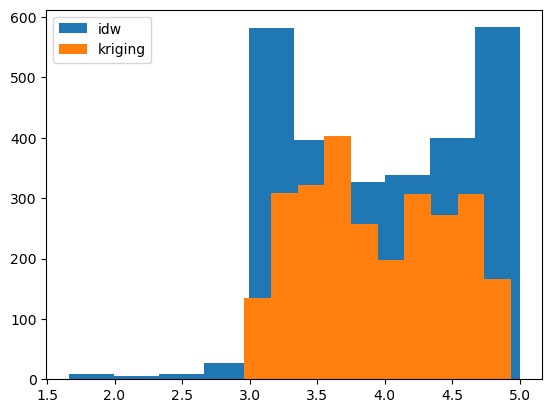

In [89]:
plt.hist(preds[:, 2], label='idw')
plt.hist(geotest['kriging'], label='kriging')
plt.legend()
plt.show()

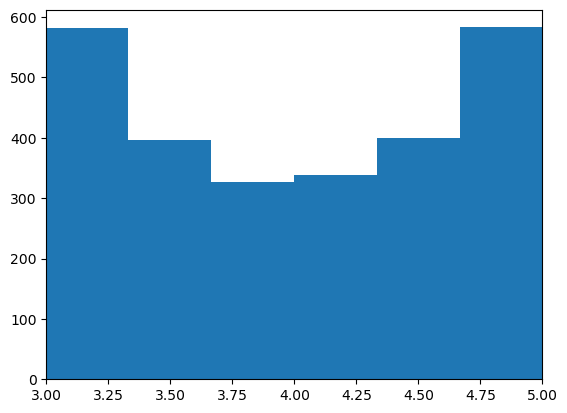

In [90]:
plt.hist(preds[:, 2], label='idw')
plt.xlim(3, 5)
plt.show()

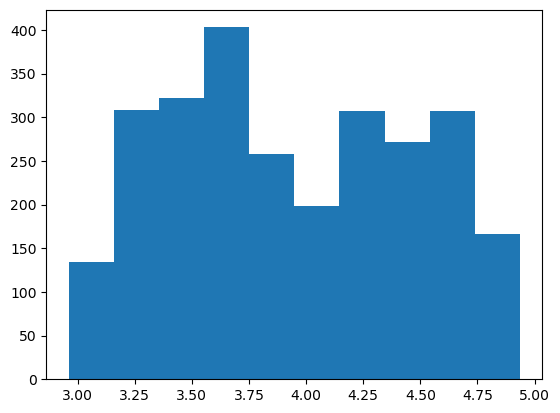

In [91]:
plt.hist(geotest['kriging'], label='kriging')
plt.show()

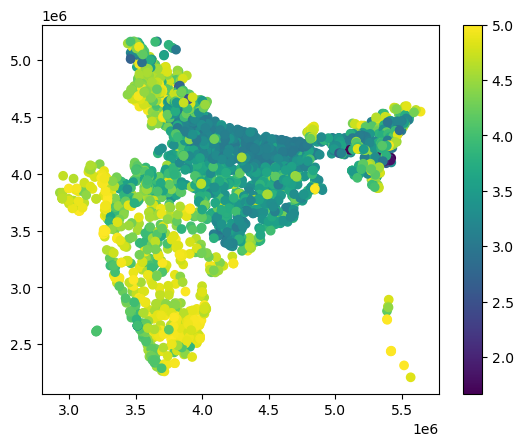

In [104]:
plt.figure()
plt.scatter(preds[:, 0], preds[:, 1], c=preds[:,2])
plt.colorbar()

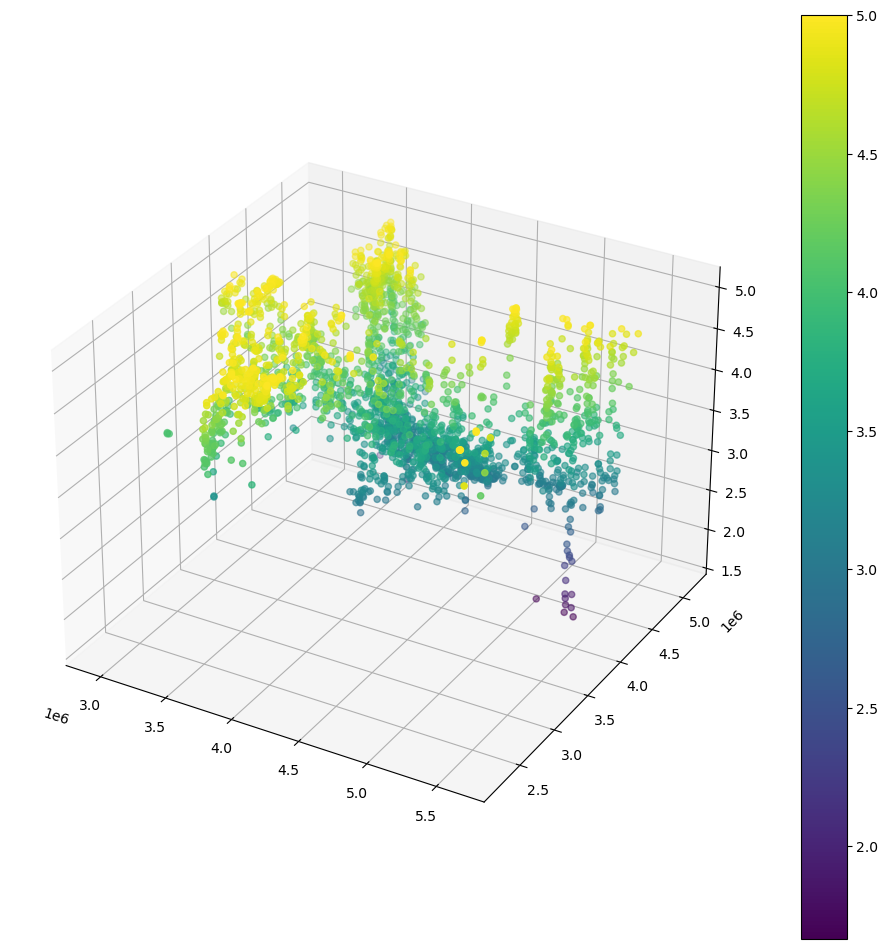

In [105]:
from matplotlib import cm
figure = plt.figure(figsize=(12, 12), facecolor='w')
ax = figure.add_subplot(111, projection='3d')
p = ax.scatter3D(preds[:, 0], preds[:, 1], preds[:, 2],
                c=preds[:, -1], cmap='viridis')
figure.colorbar(p)
plt.show()